# NODULE VISUALIZATION

In this notebook I want to examine some CT scans to find the nodules inside them. Note that the annotations file used is the one obtained with the "Full_annotations.ipynb" notebook but also the original annotations.csv (from LUNA16 download page) file can be used.

In [1]:
import pandas as pd
import numpy as np

import SimpleITK as sitk
import cv2

import matplotlib.pyplot as plt

from Config import *

In [4]:
# read the annotations file
df = pd.read_csv(ANNOTATIONS_DIR + '/full_annotations.csv', sep=';').drop(columns=['Unnamed: 0'])
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,malignancy_Level,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,4,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,4,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,3,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,5,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,5,0


In [2]:
# first CT scan
img_path = DATASET_DIR + '/volumes/images/subset0/'
img_name = '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd'

image = sitk.ReadImage(img_path + img_name)
image_array = sitk.GetArrayFromImage(image)

print(f'Shape: {image_array.shape}')

Shape: (119, 512, 512)


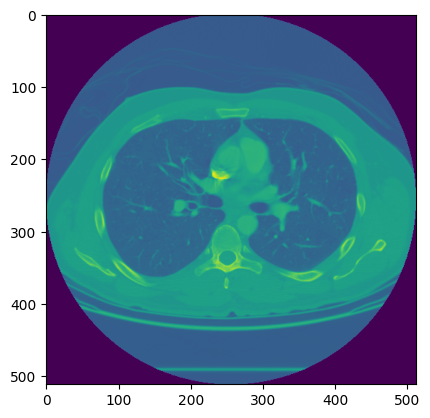

In [3]:
# show one random slice
plt.imshow(image_array[60])
plt.show()

In [6]:
# extract the annotations of the nodules present in the scan
scan_df = df[df.seriesuid == img_name[:-4]] 
scan_df

,seriesuid,coordX,coordY,coordZ,diameter_mm,malignancy_Level,class
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,3,1


In [7]:
# extract nodules coordinates
x, y, z, diameter = scan_df['coordX'].item(), scan_df['coordY'].item(), scan_df['coordZ'].item(), scan_df['diameter_mm'].item()
print(f'x: {x}, y: {y}, z: {z}, diameter: {diameter}')

# coordinates conversion: world to voxel
spacing = image.GetSpacing()
origin = image.GetOrigin()

x_v = (x - origin[0]) / spacing[0]
y_v = (y - origin[1]) / spacing[1]
z_v = (z - origin[2]) / spacing[2]

print(f'x: {x_v}, y: {y_v}, z: {z_v}') # -> float

# faster way to convert
x_v, y_v, z_v = image.TransformPhysicalPointToIndex((x, y, z)) # -> returns int
print(f'x: {x_v}, y: {y_v}, z: {z_v}')

x: -100.5679445, y: 67.26051683, z: -231.816619, diameter: 6.440878725
x: 110.39259332811388, y: 346.62447366274836, z: 32.7733524
x: 110, y: 347, z: 33


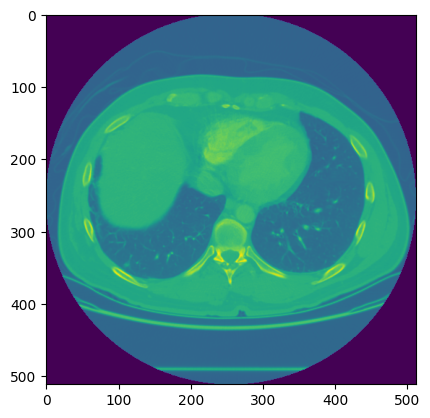

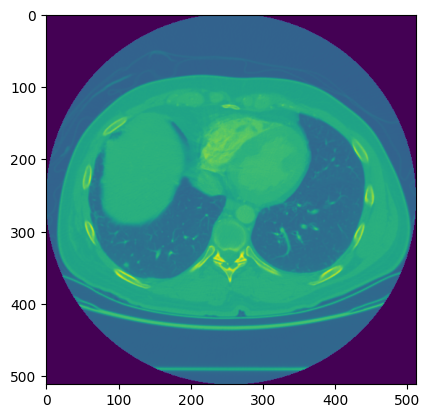

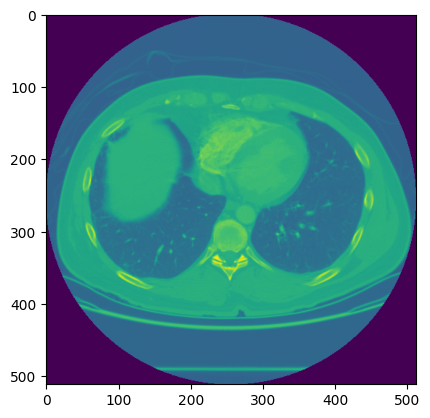

In [8]:
# show three slices of the scan: the one with nodule (z_v), the one before and the one after
plt.imshow(image_array[z_v-1])
plt.show()
plt.imshow(image_array[z_v])
plt.show()
plt.imshow(image_array[z_v+1])
plt.show()

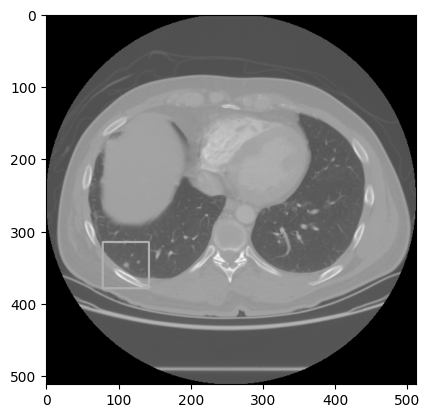

In [10]:
# plot a rectangle around nodule in the central slice (z = z_v)
slice_0 = image_array[z_v]
s = cv2.rectangle(slice_0, (x_v-32, y_v+32), (x_v + 32, y_v -32), (255, 255, 255), 2)
plt.imshow(s, cmap='gray')

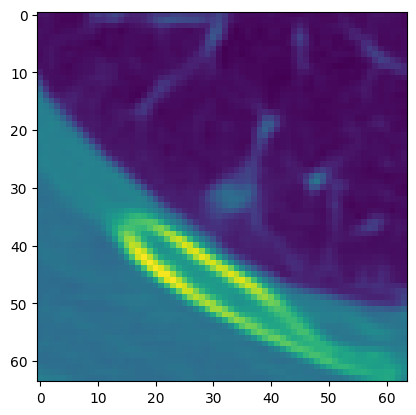

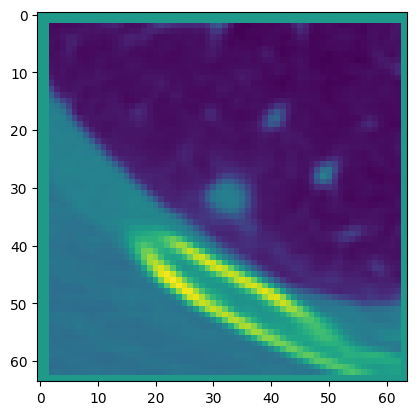

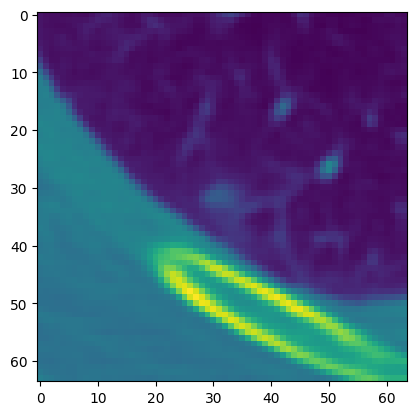

In [14]:
# extract nodule voxel of shape (3, 64, 64) extracting a patch of 64x64 around the nodule from the three slices shown before
nodule_voxel = []

slice_before = image_array[z_v - 1]
nodule_voxel.append(slice_before[y_v-32:y_v+32, x_v-32:x_v+32])

slice_current = image_array[z_v] # this slice has the rectangle still drawn
nodule_voxel.append(slice_current[y_v-32:y_v+32, x_v-32:x_v+32])

slice_after = image_array[z_v + 1]
nodule_voxel.append(slice_after[y_v-32:y_v+32, x_v-32:x_v+32])

nodule_voxel = np.array(nodule_voxel)

for i in range(len(nodule_voxel)):
    plt.imshow(nodule_voxel[i])
    plt.show()

In [16]:
# second CT scan
img_name = '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd'

image = sitk.ReadImage(img_path + img_name)
image_array = sitk.GetArrayFromImage(image)

print(f'Shape: {image_array.shape}')

# extract the annotations of the nodules present in the scan
scan_df = df[df.seriesuid == img_name[:-4]] 
scan_df

Shape: (161, 512, 512)


,seriesuid,coordX,coordY,coordZ,diameter_mm,malignancy_Level,class
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,5,0
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,5,0


In [28]:
# in this case the scan has two nodules -> create list for coordinates and diameter
coords_list = []
for index, row in scan_df.iterrows():    
    coords_dict = {
        'x': row['coordX'],
        'y': row['coordY'],
        'z': row['coordZ'],
        'diameter': row['diameter_mm']
    }
    
    coords_list.append(coords_dict)

coords_list

[{'x': 46.18853869,
  'y': 48.40280596,
  'z': -108.5786324,
  'diameter': 13.59647134},
 {'x': 36.39204443,
  'y': 76.77166265,
  'z': -123.3219112,
  'diameter': 4.343199739}]

x: 426, y: 286, z: 68


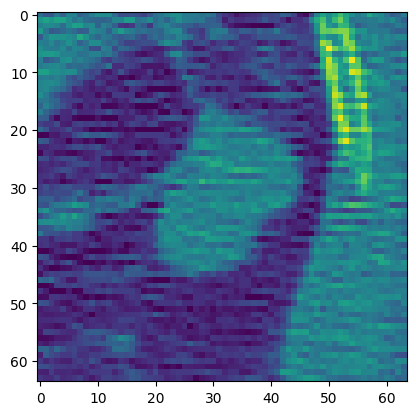

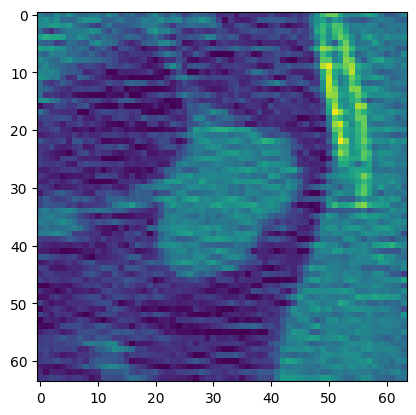

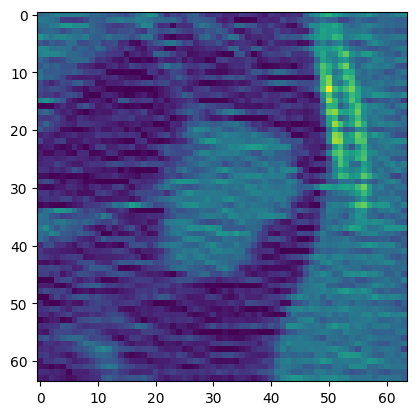

In [32]:
# extract first nodule voxel
idx = 0
x, y, z = coords_list[idx]['x'], coords_list[idx]['y'], coords_list[idx]['z']
x_v, y_v, z_v = image.TransformPhysicalPointToIndex((x, y, z)) # -> returns int
print(f'x: {x_v}, y: {y_v}, z: {z_v}')

nodule_voxel = []

slice_before = image_array[z_v - 1]
nodule_voxel.append(slice_before[y_v-32:y_v+32, x_v-32:x_v+32])

slice_current = image_array[z_v] # this slice has the rectangle still drawn
nodule_voxel.append(slice_current[y_v-32:y_v+32, x_v-32:x_v+32])

slice_after = image_array[z_v + 1]
nodule_voxel.append(slice_after[y_v-32:y_v+32, x_v-32:x_v+32])

nodule_voxel = np.array(nodule_voxel)

for i in range(len(nodule_voxel)):
    plt.imshow(nodule_voxel[i])
    plt.show()

x: 408, y: 337, z: 57


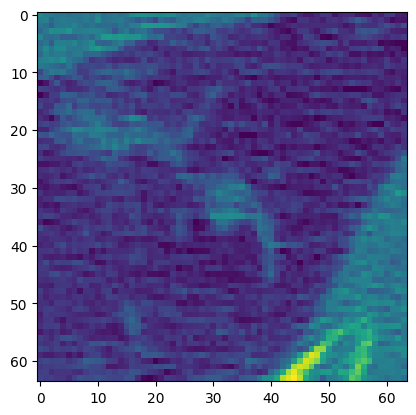

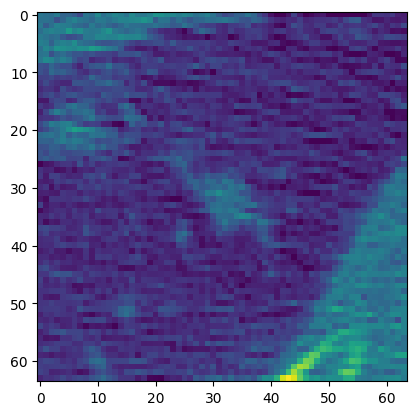

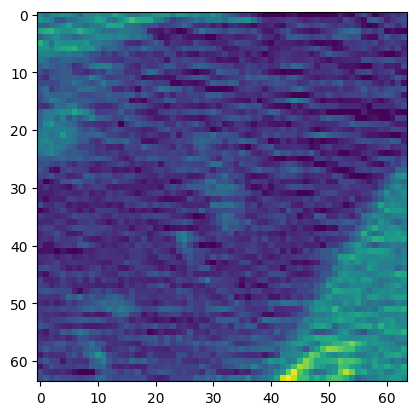

In [34]:
# extract second nodule voxel
idx = 1
x, y, z = coords_list[idx]['x'], coords_list[idx]['y'], coords_list[idx]['z']
x_v, y_v, z_v = image.TransformPhysicalPointToIndex((x, y, z)) # -> returns int
print(f'x: {x_v}, y: {y_v}, z: {z_v}')

nodule_voxel = []

slice_before = image_array[z_v - 1]
nodule_voxel.append(slice_before[y_v-32:y_v+32, x_v-32:x_v+32])

slice_current = image_array[z_v] # this slice has the rectangle still drawn
nodule_voxel.append(slice_current[y_v-32:y_v+32, x_v-32:x_v+32])

slice_after = image_array[z_v + 1]
nodule_voxel.append(slice_after[y_v-32:y_v+32, x_v-32:x_v+32])

nodule_voxel = np.array(nodule_voxel)

for i in range(len(nodule_voxel)):
    plt.imshow(nodule_voxel[i])
    plt.show()